# TP d'optimisation
## Méthodes d'optimisation pour la régression logistique pénalisée lasso

On veut comparer les algorithmes ADMM et SGD sur la régression logistique pénalisée lasso.

On considère que l'on observe les couples $(y_i,X_i)$ avec $y_i \in \{ -1, 1\}$ et $X_i \in \mathbb R^p$ dont la vraisemblance au point $\beta \in \mathbb R^p$ est donnée par 
$$
\prod_{i=1}^n \frac{1}{1+\exp(-y_i X_i \beta)}.
$$

On veut donc résoudre
$$
\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(1 + \exp(-y_i X_i \beta) \big)+  \lambda\| \beta \|_{\ell_1}
$$
ou
$$
-\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(\frac{1}{1 + \exp(-y_i X_i \beta)} \big)+  \lambda\| \beta \|_{\ell_1}
=-\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(\sigma(y_i X_i \beta) \big)+  \lambda\| \beta \|_{\ell_1}$$

## Simulation dans un modèle logistique

### Choix des valeurs de $n$ et $p$

In [1]:
n_features = 50
n_samples = 2000

### Choix des valeurs de $\beta^\star$

On pose $\beta^\star_j = (-1)^{j-1} \exp(-(j-1)/10)$.

C:\Users\FireBee\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


Text(0.5, 1.0, 'Parameters')

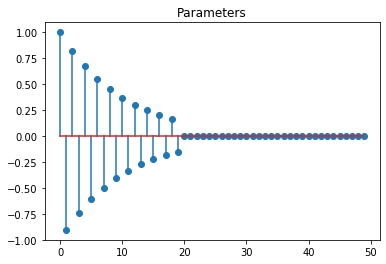

In [2]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
idx = np.arange(n_features)

params = (-1) ** idx  * np.exp(-idx / 10.)
params[20:] = 0.
plt.stem(params)
plt.title("Parameters")

### Simulation de la matrice X (features)

In [3]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz

# Correlation
rho = 0.1
# Matrice de covariance Toeplitz

np.set_printoptions(precision=2) # pour simplifier l'affichage
cov = toeplitz(rho ** np.arange(0, n_features))

# Simulation d'un vecteur gaussien de taille n 
#avec cette matrice de covariance
features = multivariate_normal(np.zeros(n_features), 
                               cov, size=n_samples)

### Simulations des $y_i$

Coder une fonction **sigmoïd**. Attention aux overflows possibles !

In [4]:
def sigmoid(u):
    """
    u np.array
    """
    idx = u>0
    out = np.empty(u.size)
    out[idx] = 1 / (1+ np.exp(-u[idx]))
    exp_u = np.exp(u[~idx])
    out[~idx] = exp_u / (1+ exp_u)
    return(out)

In [5]:
sigmoid(np.array([0]))

array([0.5])

Coder une fonction **simu_log_reg** qui pour $n$, $\beta^\star$ et $\rho$ renvoie une matrice de features et un vecteur de labels.

In [6]:
from numpy.random import binomial

In [7]:
def simu_logreg(n_samples,params=params,rho=0.1):
    """ simulation in a logistic regression model 
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    n_samples : `int`, 
        Number of samples to simulate
    rho : `float`, default=0.1
        Correlation of the features
    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
    Simulated features matrix. It samples of a centered Gaussian
    vector with covariance given by the Toeplitz matrix
    y : `numpy.array`, shape=(n_samples,)
                 Simulated labels
    """
    n_features = params.size
    
    cov = toeplitz(rho ** np.arange(0, n_features))
    
    features = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    
    pis = sigmoid(features.dot(params))
    
    labels = 2 *  binomial(1,pis, n_samples) - 1
    
    return((features,labels))

In [8]:
X,y = simu_logreg(2000)
print(y.shape)
print(X.shape)

(2000,)
(2000, 50)


# Descente de gradient proximal

On retourne au cas de la régression logistique pénalisée lasso.

On veut donc résoudre
$$
\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(1 + \exp(-y_i X_i \beta) \big)+  \lambda\| \beta \|_{\ell_1}
$$

- Faire une nouvelle classe **logreg_l1** sur le modèle de la classe **logreg** en ajoutant un méthode  qui calcule l'opérateur proximal de la norme 1 et en changeant la méthode objectif

In [9]:
from numpy.linalg import norm
class Logreg_l1:
    """       
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    lamb : `float`, 
        value of the regularization parameter
    """
    def __init__(self,X,y,lamb):
        self.X = X
        self.y = y
        self.lamb = lamb
        self.n_samples, self.n_features = X.shape

    def loss(self,w):
        u = self.y * self.X.dot(w) 
        return -np.sum(np.log(sigmoid(u))) / self.n_samples

    def grad(self,w):
        u = self.y * self.X.dot(w) 
        return self.X.T.dot(self.y  * (sigmoid(u) - 1)) / self.n_samples

    def pen(self,w):
        return self.lamb * np.sum(np.abs(w))      
    
    def prox(self,w,step):
        w_abs = np.abs(w)
        return np.sign(w) * (w_abs - self.lamb *step) *( w_abs > self.lamb * step)
    
    def lip_const(self):
        return (1/(4*self.n_samples)) * np.sum(norm(X,axis=0, ord =2))

    def objective(self,w):
        return(self.loss(w) + self.pen(w))
  
    def hessian(self,w):
        u = self.y * self.X.dot(w)
        var = sigmoid(u) * (1- sigmoid(u))
        W = np.diag(var)
        hessian = (1/self.n_samples) * self.X.T.dot(W).dot(self.X)
        return hessian


In [10]:
lamb=0.01
print(y.shape)
print(X.shape)
model_logreg_l1 = Logreg_l1(X,y,lamb)

(2000,)
(2000, 50)


In [11]:
from scipy.optimize import check_grad
print(check_grad(model_logreg_l1.loss, model_logreg_l1.grad, params))

1.600562369377751e-08


## Proximal gradient descent

Coder une fonction **pgd** qui code l'algorithme descente de gradient proximal (sur le modèle de la fonction **gd**).

In [12]:
def pgd(model, w0, step=None, n_iter=50, verbose=True):
    """Proximal gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.objective(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step == None:
            step = 1 / (model.lip_const())
    #######################################################################
        w_new[:] =  model.prox( w- step * model.grad(w) , step )
        w[:] = w_new
    #######################################################################
        obj = model.objective(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.3e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [13]:
w0 = np.zeros(n_features)
n_iter = 50
w_pgd , obj_pgd = pgd(model_logreg_l1, w0, n_iter=50)

Lauching PGD solver...
   it    |   obj   
       0 | 5.511e-01
      10 | 5.193e-01
      20 | 5.192e-01
      30 | 5.192e-01
      40 | 5.192e-01
      50 | 5.192e-01


Coder un arrêt prematuré quand $tol = 1e-03 > \|w_{\text{new}} - w\|/\|w\|$

In [14]:
def pgd2(model, w0, step=None, n_iter=50, verbose=True, tol=1e-03):
    """Proximal gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.objective(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    if step == None:
            step = 1 / (model.lip_const())
    for k in range(n_iter + 1):
    #######################################################################
        w_new[:] =  model.prox( w- step * model.grad(w) , step )
        if (np.sum(np.abs(w_new-w))/np.sum(np.abs(w))< tol):
            break
        w[:] = w_new
    #######################################################################
        obj = model.objective(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.3e" % obj).rjust(8)]))
    return w, np.array(objectives)


In [15]:
w0 = np.zeros(n_features)
w_pgd2 , obj_pgd2 = pgd2(model_logreg_l1,w0)

Lauching PGD solver...
   it    |   obj   
       0 | 5.511e-01
      10 | 5.193e-01


C:\Users\FireBee\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


# ADMM 

- Coder un algorithme ADMM pour ce problème
- Comparer ses performances au PGD classique et au SPGD

On veut$$
\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(1 + \exp(-y_i X_i \beta) \big)+  \lambda\| \beta \|_{\ell_1}
$$
Dans ce cas là, en utilisant ADMM, on a le problème d'optimization suivant:
$$
\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(1 + \exp(-y_i X_i \beta) \big)+  \lambda\| z \|_{\ell_1}
$$
$$ \text{subject to } \beta = z$$


On a 
$$\beta^{(k+1)} = \arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(1 + \exp(-y_i X_i \beta) \big)+{\rho/2 }\|(\beta ^{(k)}-z^{(k)}+u^{(k)}\|_{\ell_2}$$
$$z^{(k+1)} = \arg\min_z \lambda\| \beta \|_{\ell_1}+{\rho/2 }\|(\beta ^{(k+1)}-z^{(k)}+u^{(k)}\|_{\ell_2}
 = S_{\lambda /\rho}(\beta^{(k+1)}+u^{(k)})$$
$$u^{(k+1)} = u^{(k)} + \beta^{(k+1)} - z^{(k+1)}$$


On calcule $\beta^{(k+1)}$ par le méthode de Newton 
$$\beta^{(k+1)} = \beta^{(k)} - ({\rho}Id + \nabla^2_f (\beta^{(k)}))^{-1}(\nabla f(\beta^{(k)}) + {\rho/2}(\beta^{(k)}-z^{(k)}+u^{(k)}))$$

Et calcule $z^{(k+1)}$ en utilisant la fonction **prox** dans la classe **Logreg_l1**.

Le **step**, dans l'ADMM c'est ${\rho}$ soit fixe ou varié.

In [16]:
def admm(model, w0, step=None, n_iter=50, verbose=True, tol=1e-04, update_step=True):
    """Proximal gradient descent
    """
    w = w0.copy()
    z = w0.copy()
    u = w0.copy()
    w_new = w0.copy()

    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.objective(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    if step == None:
        step = 1 / model.lip_const()
    for k in range(n_iter + 1):
    #######################################################################
        invHessian = np.linalg.inv(model.hessian(w)+1/step*np.eye(len(w0)))
        w_new = w - invHessian.dot(model.grad(w)+1/step*(w-z+u))
        z_new = model.prox(w_new + u, step)
        u = u + w_new - z_new
        
        ############################### Update step ###############################
        if update_step == True:
            if (np.linalg.norm(w_new - z_new) > 15/step*np.linalg.norm(z_new - z)):
                step = step / 2
            elif (15*np.linalg.norm(w_new - z_new) < 1/step*np.linalg.norm(z_new - z)):
                step = step * 2
        ###########################################################################
        
        if (np.sum(np.abs(w_new-w))/np.sum(np.abs(w))< tol):
            break
            
        w[:] = w_new
        z[:] = z_new
        
    #######################################################################
        obj = model.objective(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.3e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [17]:
w0 = np.zeros(n_features)
w_admm , obj_admm = admm(model_logreg_l1,w0, n_iter=50, verbose=True)

Lauching GD solver...
   it    |   obj   
       0 | 5.850e-01


C:\Users\FireBee\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


      10 | 5.196e-01
      20 | 5.192e-01
      30 | 5.192e-01


In [18]:
w0 = np.zeros(n_features)
mu = 10
t_incr = 2
t_decr = 2
w_admm2 , obj_admm2 = admm(model_logreg_l1,w0, n_iter=50, verbose=True, update_step=False)

Lauching GD solver...
   it    |   obj   
       0 | 5.850e-01


C:\Users\FireBee\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


      10 | 5.196e-01
      20 | 5.192e-01
      30 | 5.192e-01


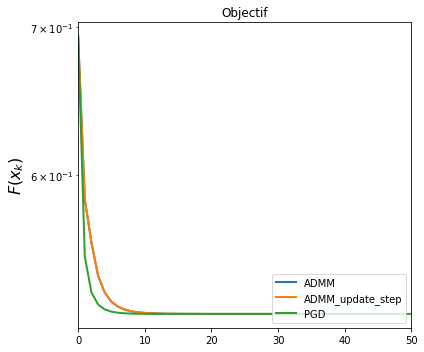

In [19]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_admm2 , label="ADMM", lw=2)
plt.plot(obj_admm , label="ADMM_update_step", lw=2)
plt.plot(obj_pgd , label="PGD", lw=2) 
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower right')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()

Dans ce problem, avec la valeur par défaut de step: **step = 1/lip_const**, on peut voir que le PGD converge plus vite que les ADMM. On teste avec la valeur de step plus petite: **step = 1/(lip_const*10)**

In [20]:
w0 = np.zeros(n_features)
step = 1 / (10*model_logreg_l1.lip_const())
w_pgd , obj_pgd = pgd(model_logreg_l1, w0, step, n_iter=50)

Lauching PGD solver...
   it    |   obj   
       0 | 6.719e-01
      10 | 5.699e-01
      20 | 5.407e-01
      30 | 5.295e-01
      40 | 5.245e-01
      50 | 5.221e-01


In [21]:
w_admm , obj_admm = admm(model_logreg_l1, w0, step, n_iter=50, verbose=True)

Lauching GD solver...
   it    |   obj   
       0 | 6.707e-01


C:\Users\FireBee\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


      10 | 5.233e-01
      20 | 5.193e-01
      30 | 5.192e-01
      40 | 5.192e-01


In [22]:
w_admm2 , obj_admm2 = admm(model_logreg_l1, w0, step,n_iter=50, verbose=True, update_step=False)

Lauching GD solver...
   it    |   obj   
       0 | 6.707e-01


C:\Users\FireBee\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


      10 | 5.737e-01
      20 | 5.430e-01
      30 | 5.308e-01
      40 | 5.253e-01
      50 | 5.225e-01


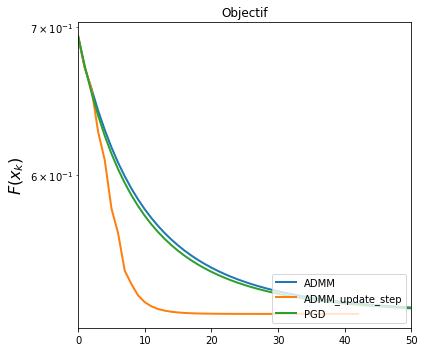

In [23]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_admm2 , label="ADMM", lw=2)
plt.plot(obj_admm , label="ADMM_update_step", lw=2)
plt.plot(obj_pgd , label="PGD", lw=2) 
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower right')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()

Le PGD converge encore plus vite que le ADMM avec le **step** constant. 
Mais le ADMM avec le **step** mise à jour à chaque itération, il a montré de l'avantage dans ce cas.